<a href="https://colab.research.google.com/github/EngSaraMahrous/Deep-Learning-nlp-project/blob/main/master_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import keras
import math
import subprocess
import pickle
import pandas as pd
import urllib.parse as urlenc
from collections import Counter
import tensorflow
from tensorflow.keras import layers
from pandas import DataFrame
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
dataset = "attack.csv, normal.csv 'CSIC2012'"
# dataset = "pkdd"
# dataset = "httpparam"
# df = pd.read_csv('Httpparamdataset.csv')
#df = pd.read_csv(dataset)
normal= pd.read_csv('normal.csv')
attack= pd.read_csv('attack.csv')
df = [normal, attack]
df = pd.concat(df)
# df = pd.read_csv('pkdd.csv')


In [ ]:
def counter_word(text_col):
    pure_num = 0
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
            pure_num += 1
    return count


In [ ]:


counter = counter_word(df.payload)
num_unique_words = len(counter)

train_df = df

train_sentences = train_df.payload.to_numpy()#[and union ] nro

tokenizer = Tokenizer(num_words=num_unique_words)

#cut sentences into words
tokenizer.fit_on_texts(train_sentences)
#convert words into integer
train_sequences = tokenizer.texts_to_sequences(train_sentences)

array = []
for i in range(len(train_sequences)):
  array.append(len(train_sequences[i]))

unique_counter = Counter(array)
unique = unique_counter.most_common(30)
base = 0
sum = 0
for i in unique:
  sum += i[0]
  base += 1
max_length = math.ceil(sum/base)

# max_length = 20
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","))
try:
  train_labels = vectorizer.fit_transform(df.target.to_numpy()).toarray()
except Exception:
  train_labels = vectorizer.fit_transform(df.attack_type.to_numpy()).toarray()
print(vectorizer.vocabulary_)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_padded, train_labels, test_size=0.20, shuffle=True)


{'normal': 4, 'sqli': 5, 'bufferoverflow': 0, 'formatstring': 2, 'ldapi': 3, 'ssi': 6, 'xpath': 7, 'xss': 8, 'crlfi': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Bi LSTM

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

import keras;
from keras.models import Sequential;
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, Bidirectional, Embedding, LSTM;

model = keras.models.Sequential()
model.add(Embedding(num_unique_words, 16, input_length=max_length))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(len(vectorizer.vocabulary_)))
model.add(Activation('softmax'));


loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]
model.summary()
model.compile(loss=loss, optimizer=optim, metrics=metrics)

kf = KFold(n_splits = 5)
val = 0
cvscores = []

start = time.time()

for train_index, val_index in kf.split(X_train,y_train):
  print(f"""
  #   ==============
  #   Val num : {val + 1}
  #   ==============
  #   """)
  history = model.fit(X_train[train_index], y_train[train_index], validation_split=0.1, epochs=2, verbose=1)
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  val += 1

end = time.time()
print(f"\n\n The Training Duration Time for pkdd in Bi-LSTM is: {end - start}\n\n ")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# #model.save("model.h5")
# #print("saved")



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 38, 16)            395264    
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               559104    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 9)                 4617      
                                                                 
 activation_1 (Activation)   (None, 9)                 0         
                                                                 
Total params: 958985 (3.66 MB)
Trainable params: 958985 (3.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

  #   ==============
  #   Val num : 1
  #   ==============
  #   
Epoch 1/2
438/43

152/152 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0     0.5921    0.6000    0.5960        75
           1     1.0000    1.0000    1.0000        60
           2     0.3636    0.4444    0.4000         9
           3     0.7778    0.6364    0.7000        22
           4     1.0000    0.9988    0.9994      1615
           5     1.0000    1.0000    1.0000      2020
           6     0.4812    0.9846    0.6465        65
           7     0.0000    0.0000    0.0000        41
           8     1.0000    0.9749    0.9873       957

    accuracy                         0.9772      4864
   macro avg     0.6905    0.7377    0.7032      4864
weighted avg     0.9762    0.9772    0.9754      4864

Confusion Matrix



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


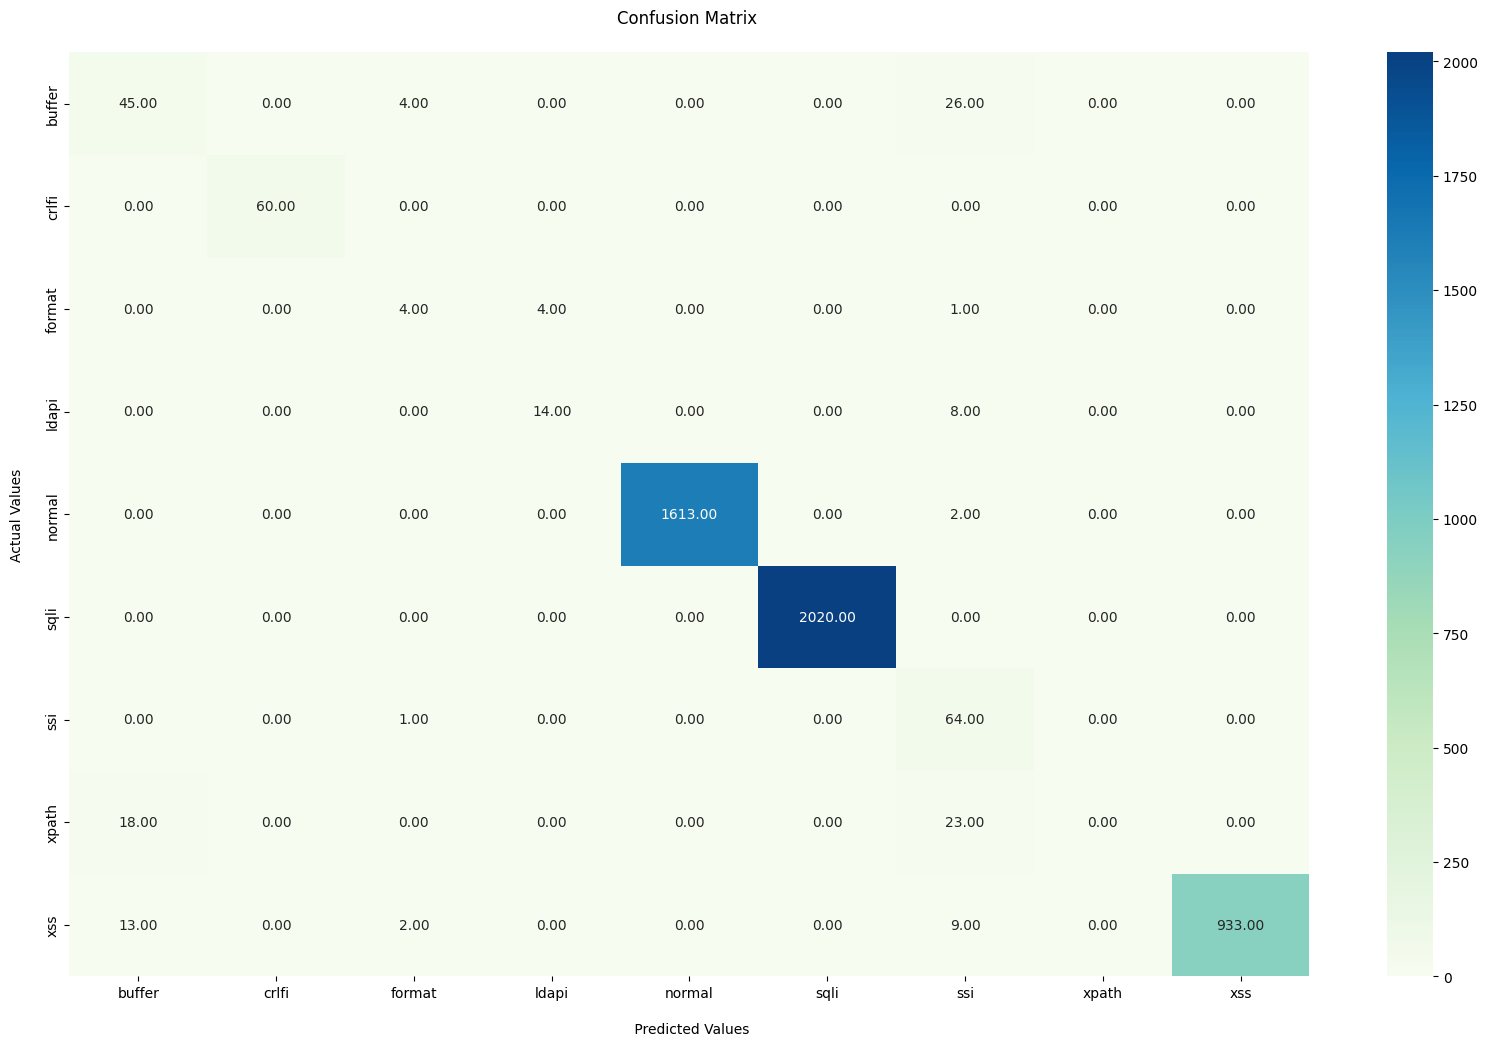



 The Testing Duration Time for attack.csv, normal.csv 'CSIC2012' in Bi-LSTM is: 1.7104997634887695

 


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

starttest = time.time()
# Predection Object
predictions = model.predict(X_test)

# Classefication Output
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), digits=4))

# The Matrix
print('Confusion Matrix\n')
plt.figure(figsize=(20,12))
fx=sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

# pkdd 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])
# fx.yaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])

# Httpparam 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])
# fx.yaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])

# csic2012 3 'Uncomment For Running'
fx.xaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])
fx.yaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])

# Show Image
plt.show()
endtest = time.time()
print(f"\n\n The Testing Duration Time for {dataset} in Bi-LSTM is: {endtest - starttest}\n\n ")


LSTM

In [ ]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 15, input_length=max_length))
model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(len(vectorizer.vocabulary_), activation="softmax"))
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.summary()

model.compile(loss=loss, optimizer=optim, metrics=metrics)

import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

val = 0
cvscores = []
for train_index, val_index in kf.split(X_train,y_train):
  print(f"""
  ==============
  Val num : {val + 1}
  ==============
  """)

  start = time.time()

  history = model.fit(X_train[train_index], y_train[train_index], validation_split=0.1, epochs=2, verbose=1)

  scores = model.evaluate(X_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  val += 1

end = time.time()
print(f"\n\n The Training Duration Time for LSTM in LSTM is: {end - start}\n\n ")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
#model.save("lstm-http.h5")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 38, 15)            370560    
                                                                 
 lstm_3 (LSTM)               (None, 64)                20480     
                                                                 
 dense_5 (Dense)             (None, 9)                 585       
                                                                 
Total params: 391625 (1.49 MB)
Trainable params: 391625 (1.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

  Val num : 1
  
Epoch 1/2
438/438 [==============================] - 21s 43ms/step - loss: 0.4238 - accuracy: 0.8588 - val_loss: 0.1526 - val_accuracy: 0.9461
Epoch 2/2
438/438 [==============================] - 6s 12ms/step - loss: 0.1499 - accuracy: 0.9517 - val_loss: 0.1138 - 

152/152 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6944    1.0000    0.8197        75
           1     1.0000    1.0000    1.0000        60
           2     0.0000    0.0000    0.0000         9
           3     0.7308    0.8636    0.7917        22
           4     0.9994    0.9938    0.9966      1615
           5     0.9995    1.0000    0.9998      2020
           6     0.6778    0.9385    0.7871        65
           7     0.6842    0.3171    0.4333        41
           8     1.0000    0.9760    0.9878       957

    accuracy                         0.9842      4864
   macro avg     0.7540    0.7877    0.7573      4864
weighted avg     0.9848    0.9842    0.9832      4864

Confusion Matrix



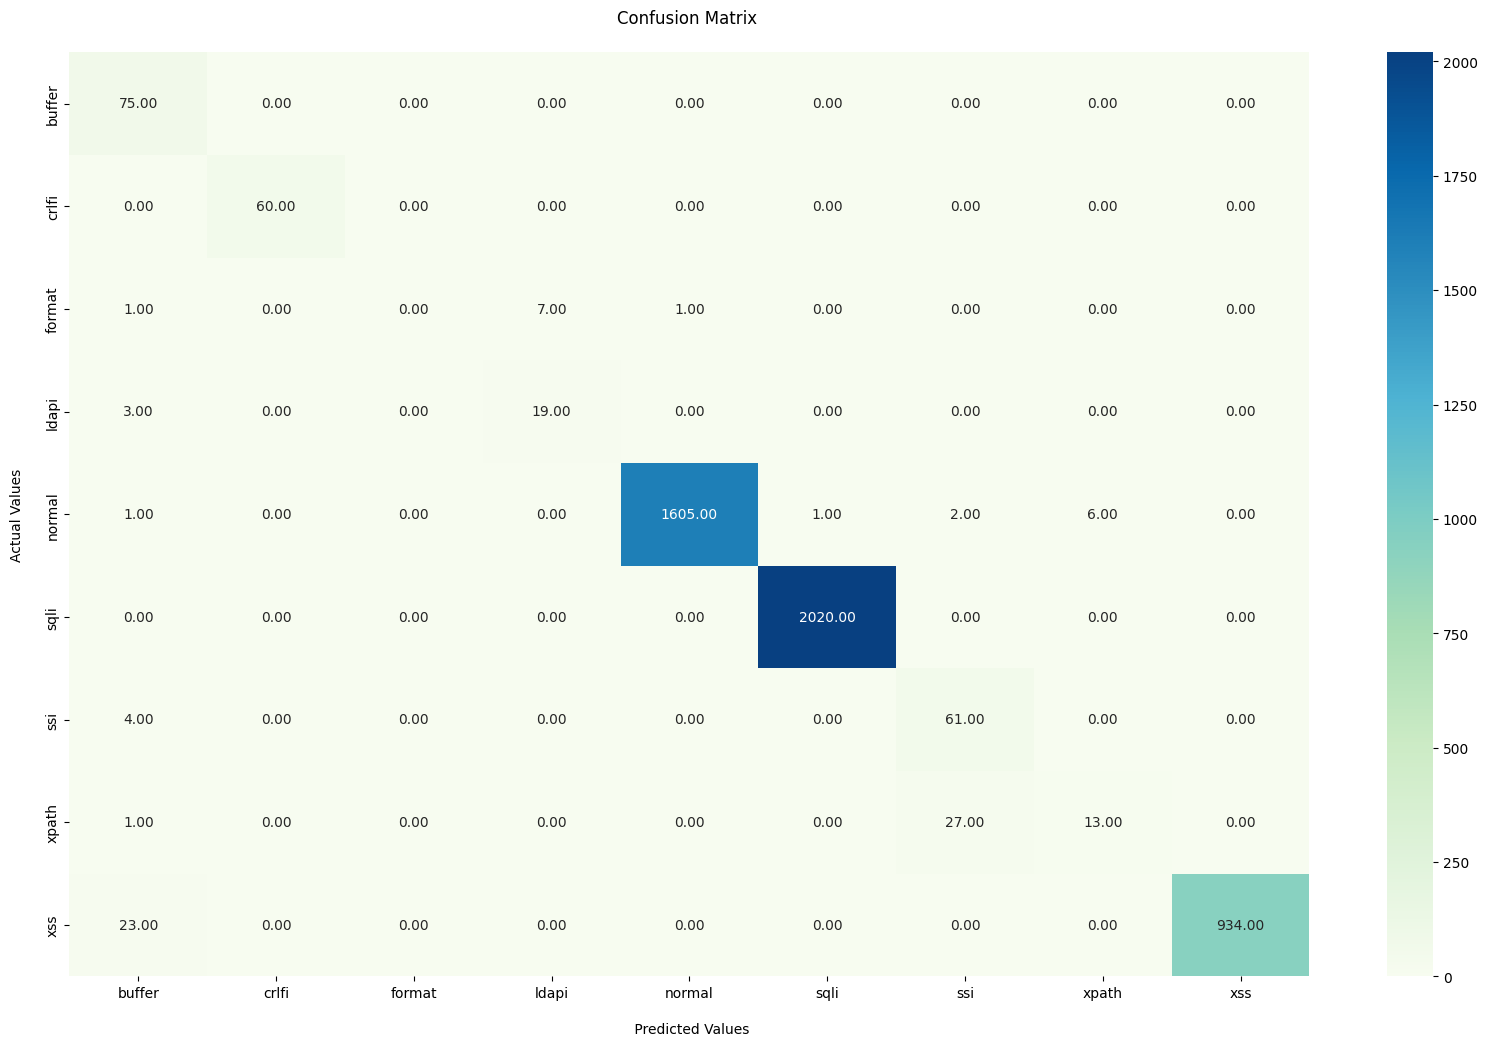



 The Training Duration Time for attack.csv, normal.csv 'CSIC2012' in LSTM is: 1.4460525512695312

 


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
starttest=time.time()
# Predection Object
predictions = model.predict(X_test)

# Classefication Output
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), digits=4))

# The Matrix
print('Confusion Matrix\n')
plt.figure(figsize=(20,12))
fx=sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

# pkdd 1 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])
# fx.yaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])

# Httpparam 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])
# fx.yaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])

# csic2012 3 'Uncomment For Running'
fx.xaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])
fx.yaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])

# Show Image
plt.show()
endtest=time.time()
print(f"\n\n The Training Duration Time for {dataset} in LSTM is: {endtest - starttest}\n\n ")

CNN

In [ ]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 15, input_length=max_length))
model.add(layers.Conv1D(5, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(len(vectorizer.vocabulary_), activation='softmax'))
model.compile(optimizer='adam',
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model.build(X_train.shape)
model.summary()

import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

val = 0
cvscores = []
for train_index, val_index in kf.split(X_train,y_train):
  print(f"""
  ==============
  Val num : {val + 1}
  ==============
  """)

  start = time.time()

  history = model.fit(X_train[train_index], y_train[train_index], epochs=2, verbose=2) # make it 1 to get a better verbose data

  scores = model.evaluate(X_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  val += 1

end = time.time()
print(f"\n\n The Training Duration Time for {dataset} in CNN is: {end - start}\n\n ")

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 38, 15)            370560    
                                                                 
 conv1d_1 (Conv1D)           (None, 34, 5)             380       
                                                                 
 global_max_pooling1d_1 (Gl  (None, 5)                 0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 9)                 54        
                                                                 
Total params: 370994 (1.42 MB)
Trainable params: 370994 (1.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

  Val num : 1
  
Epoch 1/2
487/487 - 13s - loss: 0.5913 - accuracy: 0.8506 - 13s/ep

152/152 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.6293    0.9733    0.7644        75
           1     1.0000    0.9167    0.9565        60
           2     0.8889    0.8889    0.8889         9
           3     1.0000    0.8636    0.9268        22
           4     1.0000    1.0000    1.0000      1615
           5     1.0000    1.0000    1.0000      2020
           6     0.8971    0.9385    0.9173        65
           7     0.8000    0.3902    0.5246        41
           8     1.0000    0.9843    0.9921       957

    accuracy                         0.9887      4864
   macro avg     0.9128    0.8840    0.8856      4864
weighted avg     0.9910    0.9887    0.9886      4864

Confusion Matrix



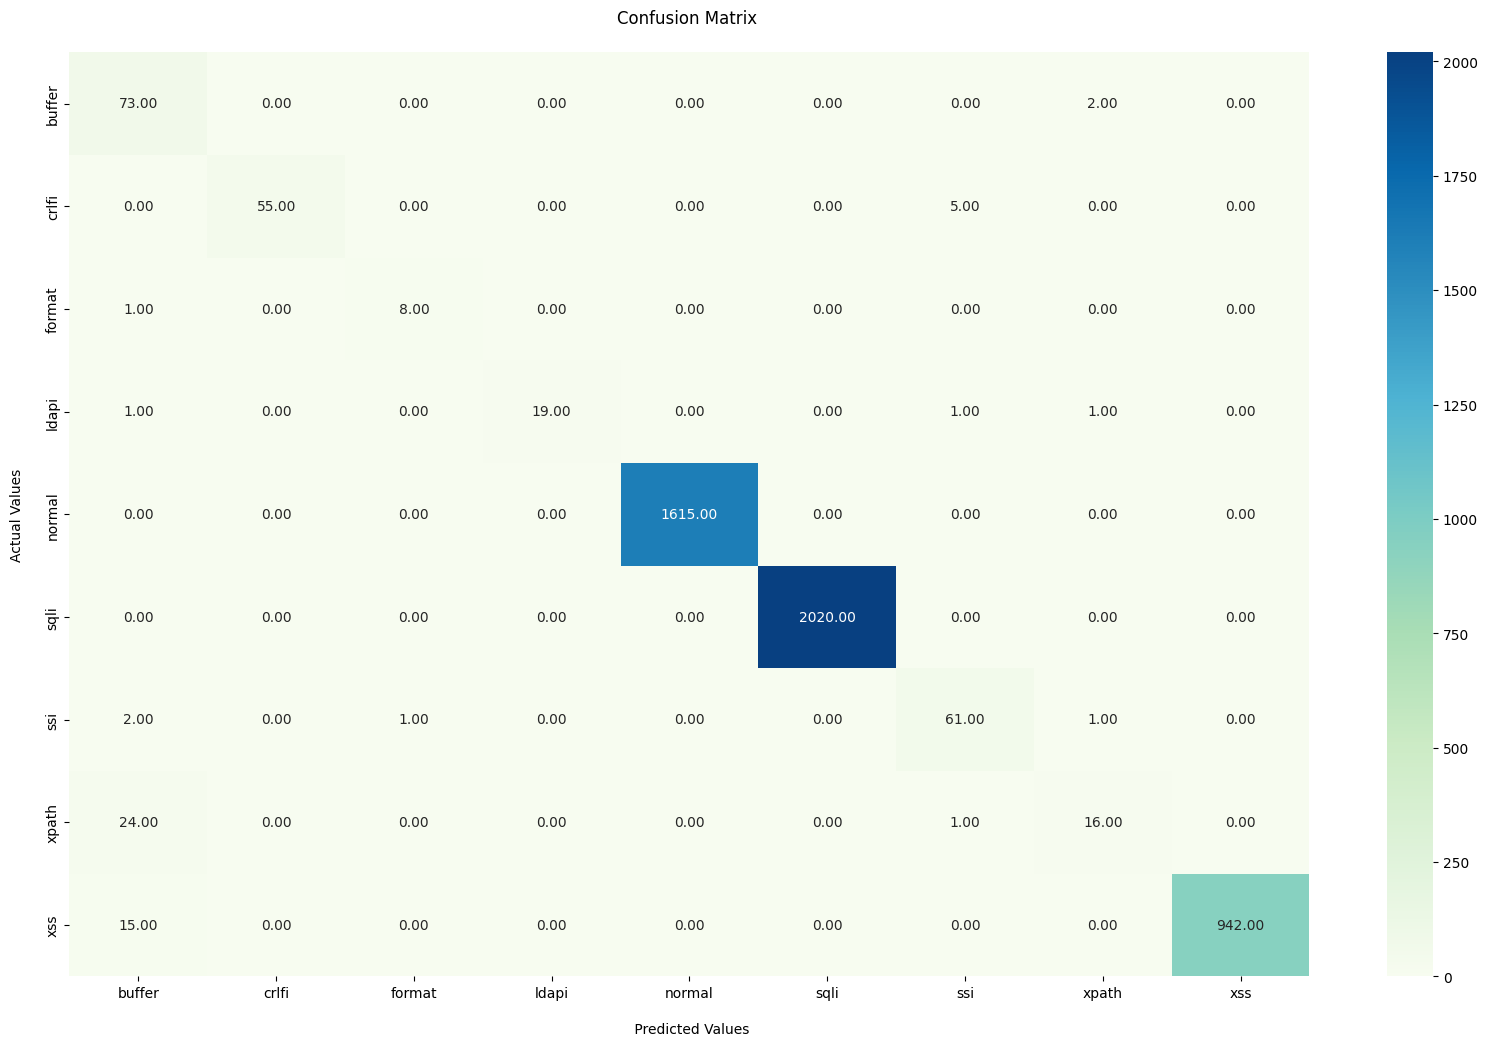



 The Training Duration Time for attack.csv, normal.csv 'CSIC2012' in CNN is: 1.4686486721038818

 


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

starttest=time.time()
# Predection Object
predictions = model.predict(X_test)

# Classefication Output
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), digits=4))

# The Matrix
print('Confusion Matrix\n')
plt.figure(figsize=(20,12))
fx=sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

# pkdd 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])
# fx.yaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])

# Httpparam 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])
# fx.yaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])

# csic2012 3 'Uncomment For Running'
fx.xaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])
fx.yaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])

# Show Image
plt.show()
endtest=time.time()
print(f"\n\n The Training Duration Time for {dataset} in CNN is: {endtest - starttest}\n\n ")

RNN

In [ ]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 15, input_length=max_length))
model.add(layers.GRU(256, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(len(vectorizer.vocabulary_), activation="softmax"))
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.summary()

model.compile(loss=loss, optimizer=optim, metrics=metrics)

import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

val = 0
cvscores = []
for train_index, val_index in kf.split(X_train,y_train):
  print(f"""
  ==============
  Val num : {val + 1}
  ==============
  """)

  start = time.time()

  history = model.fit(X_train[train_index], y_train[train_index], epochs=2, verbose=1) # here is 1

  scores = model.evaluate(X_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  val += 1

end = time.time()
print(f"\n\n The Training Duration Time for {dataset} in RNN is: {end - start}\n\n ")

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 38, 15)            370560    
                                                                 
 gru_1 (GRU)                 (None, 38, 256)           209664    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_7 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 630665 (2.41 MB)
Trainable params: 630665 (2.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

  Val num : 1
  
Epoch 1/2
487/487 [==============================] - 34s 63ms/step - loss: 0.3360 - accuracy: 0.8984
Epoch 2/2
487/487 [============

152/152 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0     0.6356    1.0000    0.7772        75
           1     0.7317    1.0000    0.8451        60
           2     0.0000    0.0000    0.0000         9
           3     0.0000    0.0000    0.0000        22
           4     1.0000    0.9895    0.9947      1615
           5     0.9995    1.0000    0.9998      2020
           6     1.0000    0.9385    0.9683        65
           7     0.8000    0.9756    0.8791        41
           8     1.0000    0.9760    0.9878       957

    accuracy                         0.9844      4864
   macro avg     0.6852    0.7644    0.7169      4864
weighted avg     0.9828    0.9844    0.9826      4864

Confusion Matrix



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


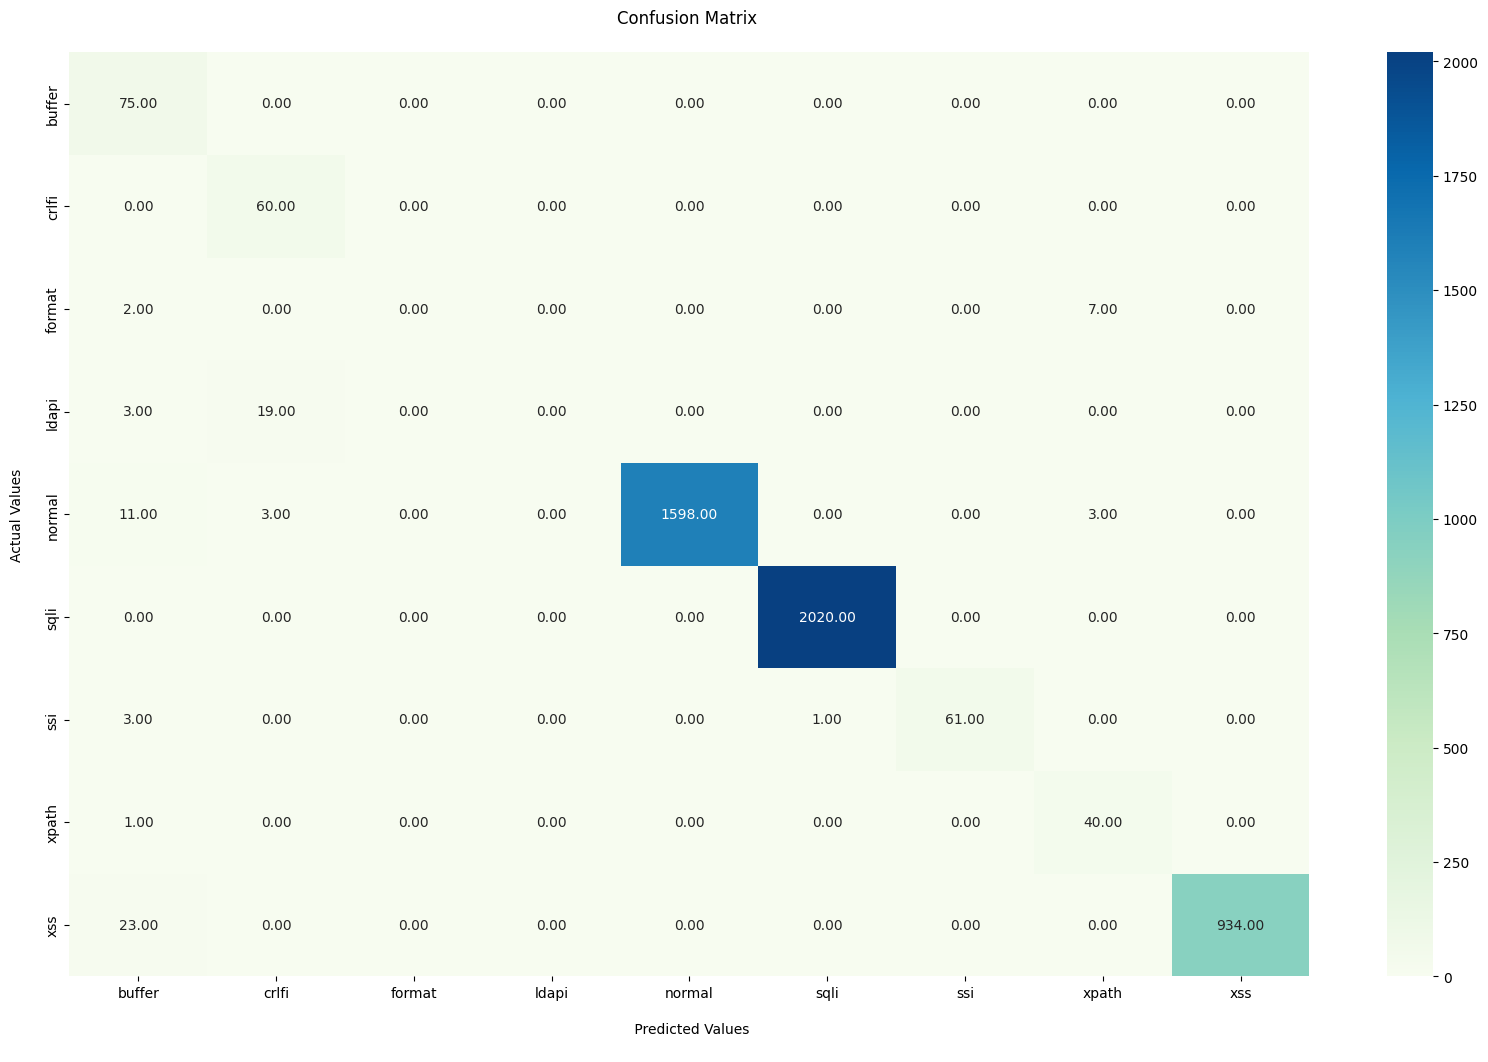



 The Training Duration Time for attack.csv, normal.csv 'CSIC2012' in RNN is: 2.411325216293335

 


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

starttest = time.time()
# Predection Object
predictions = model.predict(X_test)

# Classefication Output
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), digits=4))

# The Matrix
print('Confusion Matrix\n')
plt.figure(figsize=(20,12))
fx=sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

# pkdd 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])
# fx.yaxis.set_ticklabels(['ldapi','cmdi','pathtransversal', 'sqli', 'ssi', 'valid', 'xpath', 'xss'])

# Httpparam 'Uncomment For Running'
# fx.xaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])
# fx.yaxis.set_ticklabels(['cmdi','norm','pathtransversal', 'sqli', 'xss'])

# csic2012 3 'Uncomment For Running'
fx.xaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])
fx.yaxis.set_ticklabels(['buffer','crlfi','format', 'ldapi', 'normal', 'sqli', 'ssi', 'xpath', 'xss'])

# Show Image
plt.show()
endtest = time.time()
print(f"\n\n The Training Duration Time for {dataset} in RNN is: {endtest - starttest}\n\n ")